## 06-1 신경망 알고리즘을 벡터화하자

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [79]:
# 데이터 세트를 훈련, 검증, 테스트 세트로 나누기

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [80]:
# 시작하기 전에 사용할 데이터의 크기를 확인하는 것은 좋은 습관이다 !

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [81]:
class SingleLayer:

    def __init__ (self, learning_rate = 0.1, l1 = 0, l2 = 0):
        self.w = None  # 가중치
        self.b = None  # 절편
        self.losses = []  # 훈련 손실
        self.val_losses = []  # 검증 손실
        self.w_history = []  # 가중치 기록
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m  # 가중치에 대한 그래디언트를 계산
        b_grad = np.sum(err) / m
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)  # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a

    def reg_loss(self):
        # 가중치에 규제를 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w ** 2)

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)  # 정방향 계산
        a = self.activation(z)  # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10)  # 출력 값을 클리핑
        # 로그 손실과 규제 손실을 더해서 리스트에 추가
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교해서 True의 비율을 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def predict(self, x):
        z = self.forpass(x)
        return z > 0

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        y = y.reshape(-1, 1)  # 타깃을 열 벡터로 바꾼다
        y_val = y_val.reshape(-1, 1)
        m = len(x)  # 샘플 개수 저장
        self.w = np.ones((x.shape[1], 1))  # 가중치를 초기화
        self.b = 0  # 절편을 초기화
        self.w_history.append(self.w.copy())  # 가중치를 기록
        # epochs 만큼 반복
        for i in range(epochs):
            z = self.forpass(x)  # 정방향 계산
            a = self.activation(z)  # 활성화 함수 적용
            err = -(y - a)
            # 오차를 역전파하여 그래디언트를 계산
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 그래디언트에 페널티 항의 미문 값을 더한다
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록한다
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑하기
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)

In [82]:
# 안정적인 학습을 위해 사이킷런의 StandardScaler 클래스로 전처리하자
from sklearn.preprocessing import StandardScaler

In [83]:
# **************** 이건 내가 해본 거 그냥

print((x.shape[1], 1))

(30, 1)


In [84]:
# 훈련 데이터 표준화 전처리하기

scaler = StandardScaler()  # 객체 선언
scaler.fit(x_train)  # fit( ) 메서드로 변환 규칙을 익히고
x_train_scaled = scaler.transform(x_train)  # 훈련 세트에 표준화 적용
x_val_scaled = scaler.transform(x_val)  # 검증 세트에 표준화 적용

In [85]:
# 이 데이터를 SingleLayer 클래스 객체에 전달해서 배치 경사 하강법 적용해 보자

single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 10000)
single_layer.score(x_val_scaled, y_val)

# 에포크 횟수를 늘린 이유는 확률적 경사 하강법과 경사 하강법은 에포크마다 가중치 업데이트를 하는 횟수에 차이가 있기 때문
# score 메서드로 출력된 검증 세트의 점수는 5장과 동일하지만 손실 함수 값의 변화는 다르다.
# 훈련 손실과 검증 손실을 그래프로 출력해 보자

0.978021978021978

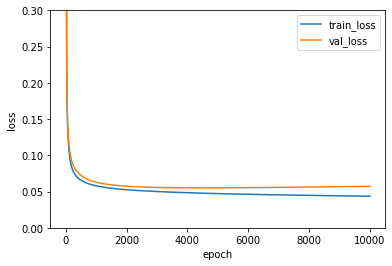

In [86]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 5장에서 봤던 그래프에 비해 손실값이 비교적 안정적으로 감소하는 것을 알 수 있다
# 왜 이런 결과가 나오는지 가중치의 변화 그래프를 살펴보자

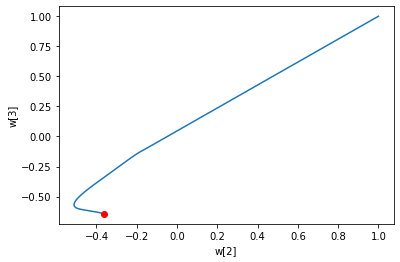

In [88]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

# 가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴된다.
# 하지만 배치 경사 하강법은 매번 전체 훈련 데이터를 사용하기 때문에 연산 비용이 많이 들고 최솟값에 수렴하는 시간도 많이 걸린다.